Running Iterations: 100%|██████████| 50/50 [30:25<00:00, 36.50s/it]

Average Accuracy (KModes - scikit-learn): 0.8659310344827585
Average Rand Index (KModes - scikit-learn): 0.5349836444390911
Average Accuracy (KModes - Custom): 0.8853793103448275
Average Rand Index (KModes - Custom): 0.5984679468516488


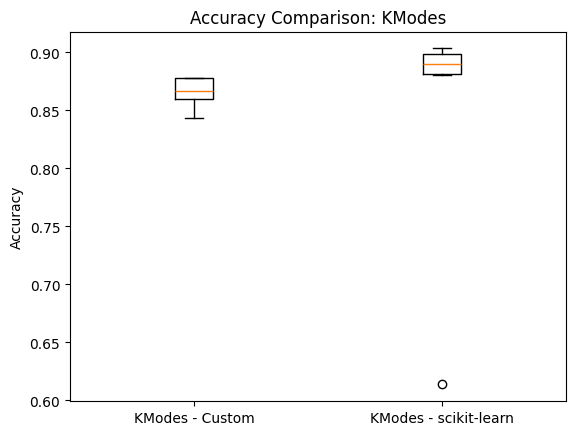

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.metrics import accuracy_score, adjusted_rand_score
from tqdm import tqdm

def initialize_centroids(data, k):
    centroids = data.sample(k).values
    return centroids

# def calculate_distance(x, centroids):     # using the squared euclidean distance
#     distances = np.sum((x - centroids) ** 2, axis=1)
#     return distances

def calculate_distance(x, centroids):     # using dissimmilarities
    distances = np.zeros(len(centroids))
    for i, centroid in enumerate(centroids):
        distances[i] = np.sum(x != centroid)
        
    return distances

def assign_clusters(data, centroids):
    distances = np.apply_along_axis(calculate_distance, 1, data.values, centroids)
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    centroids = np.zeros((k, data.shape[1]))

    for i in range(k):
        cluster_instances = data[clusters == i]

        if not cluster_instances.empty:
            for j in range(data.shape[1]):
                mode_values = cluster_instances.iloc[:, j].mode()
                if not mode_values.empty:
                    centroids[i, j] = mode_values.values[0]

    return centroids

def kmodes_plus(data, k, num_iterations=50):
    for _ in tqdm(range(num_iterations), desc="Running Iterations", leave=False):
        centroids = initialize_centroids(data, k)

        for _ in range(50):
            clusters = assign_clusters(data, centroids)
            centroids = update_centroids(data, clusters, k)
    return clusters, centroids

def align_clusters(clusters, true_labels):
    unique_clusters = np.unique(clusters)
    aligned_clusters = np.zeros_like(clusters)
    for cluster in unique_clusters:
        true_label = pd.Series(true_labels[clusters == cluster]).mode()[0]
        aligned_clusters[clusters == cluster] = true_label
    return aligned_clusters


dataset = pd.read_csv('vote.csv')
true_labels = dataset.iloc[:, -1].values

num_iterations = 50
accuracy_results = []
rand_index_results = []
sklearn_accuracy_results = []
sklearn_rand_index_results = []

for _ in tqdm(range(num_iterations), desc="Running Iterations"):
    # Using kmodes library
    kmodes_model = KModes(n_clusters=2, init='Huang', n_init=1, verbose=0)
    kmodes_clusters = kmodes_model.fit_predict(dataset.iloc[:, :-1])
    aligned_clusters = align_clusters(kmodes_clusters, true_labels) # Aligning clusters
    accuracy = accuracy_score(true_labels, aligned_clusters)
    rand_index = adjusted_rand_score(true_labels, aligned_clusters)
    accuracy_results.append(accuracy)
    rand_index_results.append(rand_index)

    # Using my custom kmodes_plus
    clusters, _ = kmodes_plus(dataset, k=2, num_iterations=50)
    aligned_clusterssklearn = align_clusters(clusters, true_labels)
    accuracy = accuracy_score(true_labels, aligned_clusterssklearn)
    rand_index = adjusted_rand_score(true_labels, aligned_clusterssklearn)
    sklearn_accuracy_results.append(accuracy)
    sklearn_rand_index_results.append(rand_index)


avg_accuracy = np.mean(accuracy_results)
avg_rand_index = np.mean(rand_index_results)
print("Custom KModes Average Accuracy :", avg_accuracy)
print("Average Rand Index (KModes - scikit-learn):", avg_rand_index)

avg_custom_accuracy = np.mean(sklearn_accuracy_results)
avg_custom_rand_index = np.mean(sklearn_rand_index_results)
print("KModes SKLearn - Average Accuracy:", avg_custom_accuracy)
print("KModes SKLearn - Average Rand Index:", avg_custom_rand_index)

plt.boxplot([accuracy_results, sklearn_accuracy_results], labels=['KModes - Custom', 'KModes - scikit-learn'])
plt.title('Accuracy Comparison: KModes')
plt.ylabel('Accuracy')
plt.show()
